In [1]:
! pip install vaderSentiment pandas_datareader textblob

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web#The Pandas library provides an API interface for obtaining financial data from financial websites, which can be used as another way to obtain stock data for quantitative trading Pandas库提供了专门从财经网站获取金融数据的API接口，可作为量化交易股票数据获取的另一种途径
import datetime as dt

import os #导入os模块到当前程序，利用其中的接口
import re #正则表达式本身是一种小型的、高度专业化的编程语言，而在python中，通过内嵌集成re模块，程序员们可以直接调用来实现正则匹配。
import io
import nltk
import json

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm #美化进度条
from sklearn import preprocessing
from time import sleep
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer #词形还原
from textblob import TextBlob 
#为了拉齐两个表的共同时间做分析
start_date = dt.datetime(2021, 2, 6)
end_date = dt.datetime(2022, 1, 28)
data = pd.read_csv('./BTC-USD.csv') #比特币原表
tweets_clean_file = './Bitcoin_tweets_clean.csv' #比特币处理后的

/Users/yeahyeah/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
tweets_clean_df = pd.read_csv(tweets_clean_file)

analyzer = SentimentIntensityAnalyzer() #compound表示复杂程度，neu表示中性，neg表示负面情绪，pos表示正面情绪。
compound = []
for i, s in enumerate(tqdm(tweets_clean_df['text'], position=0, leave=True)):
    # print(i,s)
    vs = analyzer.polarity_scores(str(s))
    compound.append(vs["compound"])
tweets_clean_df["compound"] = compound
tweets_clean_df.head(2)

100%|███████████████████████████████████| 39536/39536 [00:07<00:00, 4965.22it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound
0,465725,Josh 💎🙌,NaN,Daily #Bitcoin and #Ethereum content! Subscrib...,2016-04-29 08:45:57,19444.0,94.0,38015.0,False,2021-07-21 14:37:41,"NEW BITCOIN UPDATE!!\n\nMarket manipulation, p...",['BITCOIN'],Twitter Web App,False,-0.4724
1,3952484,Altcoin,NaN,The one stop for your altcoin news.,2021-11-28 02:52:37,94.0,11.0,10.0,False,2022-07-04 02:20:16,Tesla Reports $440M Bitcoin Lost 📉\n\nBTC bear...,"['Tesla', 'BTC', 'bearish', 'CryptoNews']",TweetDeck,False,-0.3182


In [4]:
scores = []
for i, s in tqdm(tweets_clean_df.iterrows(), total=tweets_clean_df.shape[0], position=0, leave=True):
    try:
        scores.append(s["compound"] * ((int(s["user_followers"]))) * (
                (int(s["user_favourites"]) + 1) / int(s['user_followers'] + 1)) * ((int(s["is_retweet"]) + 1)))
    except:
        scores.append(np.nan)
tweets_clean_df["score"] = scores
tweets_clean_df.head(2)

100%|██████████████████████████████████| 39536/39536 [00:02<00:00, 13675.38it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound,score
0,465725,Josh 💎🙌,NaN,Daily #Bitcoin and #Ethereum content! Subscrib...,2016-04-29 08:45:57,19444.0,94.0,38015.0,False,2021-07-21 14:37:41,"NEW BITCOIN UPDATE!!\n\nMarket manipulation, p...",['BITCOIN'],Twitter Web App,False,-0.4724,-17957.834833
1,3952484,Altcoin,NaN,The one stop for your altcoin news.,2021-11-28 02:52:37,94.0,11.0,10.0,False,2022-07-04 02:20:16,Tesla Reports $440M Bitcoin Lost 📉\n\nBTC bear...,"['Tesla', 'BTC', 'bearish', 'CryptoNews']",TweetDeck,False,-0.3182,-3.463356


# Read Bitcoin price 

In [5]:
# sentiment analysis
tweets_clean_df = tweets_clean_df.drop_duplicates()
tweets_df = tweets_clean_df.copy()
tweets_df['date'] = pd.to_datetime(tweets_df['date'], utc=True)
tweets_df.date = tweets_df.date.dt.tz_localize(None)
tweets_df.index = tweets_df['date']
print(tweets_df['date'])

tweets_sampled = tweets_df.resample('1h').sum() #推文根据时间下采样，加总，减少行数 获得每一个小时添加的推文放到一个容器里

crypto_usd = data.copy()

# crypto_usd_grouped = crypto_usd.groupby(pd.TimeGrouper('1h'))['Weighted_Price'].mean()
crypto_usd['Date'] = pd.to_datetime(crypto_usd['Date'])
print(crypto_usd['Date'])
crypto_usd.index = crypto_usd['Date']
crypto_usd_grouped = crypto_usd.resample('D')['Close'].mean() #比特币价格 以天为单位，取平均
print('cell ok')

date
2021-07-21 14:37:41   2021-07-21 14:37:41
2022-07-04 02:20:16   2022-07-04 02:20:16
2022-05-02 23:25:50   2022-05-02 23:25:50
2021-11-19 20:36:12   2021-11-19 20:36:12
2021-08-21 12:17:18   2021-08-21 12:17:18
                              ...        
2021-10-19 19:12:47   2021-10-19 19:12:47
2021-07-20 16:12:30   2021-07-20 16:12:30
2021-06-21 10:57:15   2021-06-21 10:57:15
2022-03-16 23:53:14   2022-03-16 23:53:14
2022-03-21 00:15:45   2022-03-21 00:15:45
Name: date, Length: 39536, dtype: datetime64[ns]
0      2014-09-17
1      2014-09-18
2      2014-09-19
3      2014-09-20
4      2014-09-21
          ...    
2686   2022-01-24
2687   2022-01-25
2688   2022-01-26
2689   2022-01-27
2690   2022-01-28
Name: Date, Length: 2691, dtype: datetime64[ns]
cell ok


In [6]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corrwith(datay.shift(lag), method=method)['score']

# xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, m ='pearson' ) for i in range(-20,20)]
# tweets_grouped.corrwith(crypto_usd_grouped,method='pearson')

In [7]:
beggining = max(tweets_sampled.index.min().replace(tzinfo=None), crypto_usd_grouped.index.min())
end = min(tweets_sampled.index.max().replace(tzinfo=None), crypto_usd_grouped.index.max())
tweets_sampled = tweets_sampled[beggining:end]
crypto_usd_grouped = crypto_usd_grouped[beggining:end]
print('cell ok')

cell ok


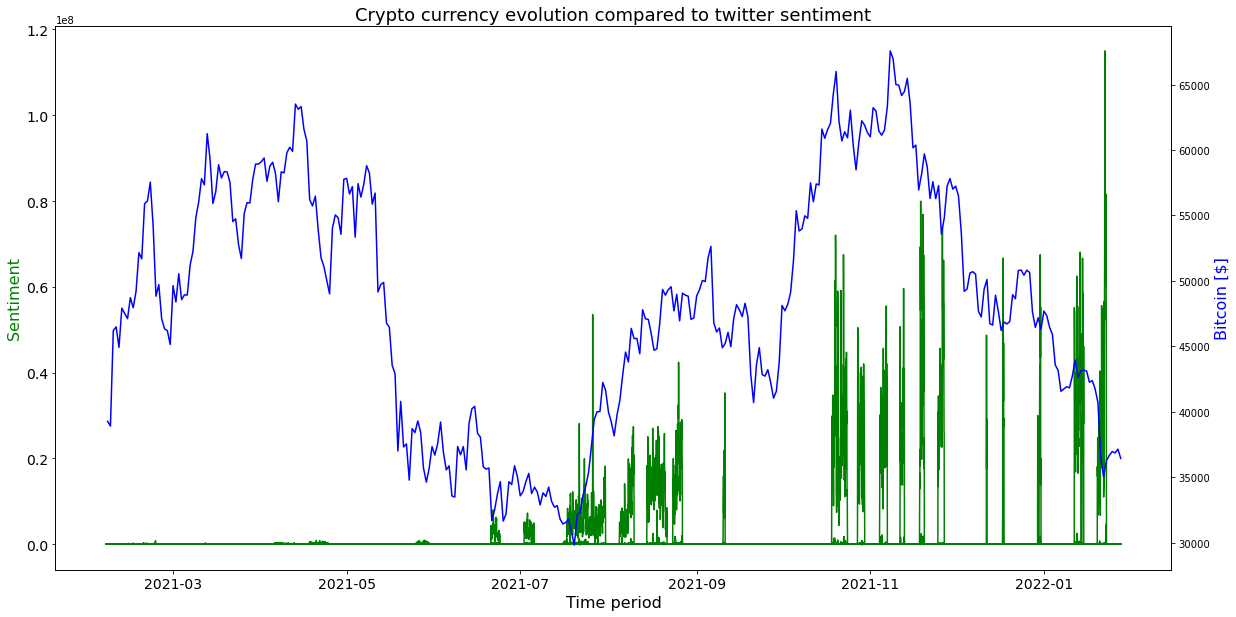

cell ok


<Figure size 432x288 with 0 Axes>

In [10]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_sampled.index.values, tweets_sampled.values, 'g-')#加.values
ax2.plot_date(crypto_usd_grouped.index.values, crypto_usd_grouped.values, 'b-')#加.values

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax1.set_xlabel("Time period", fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='b', fontsize=16)

plt.show()
plt.savefig('crypto_evolution_vs_twitter_sentiment', dpi=1000)
print('cell ok')

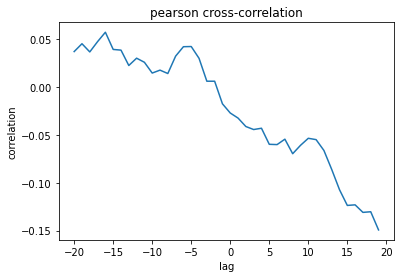

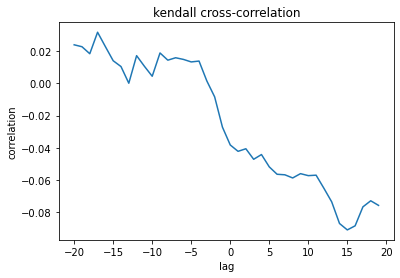

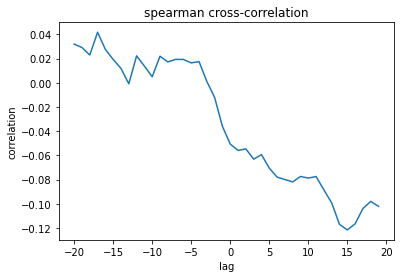

cell ok


In [11]:
xcov = [crosscorr(tweets_sampled, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20, 20)]
plt.plot(range(-20, 20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_sampled, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20, 20)]
plt.plot(range(-20, 20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_sampled, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20, 20)]
plt.plot(range(-20, 20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()
print('cell ok')

## Normalization

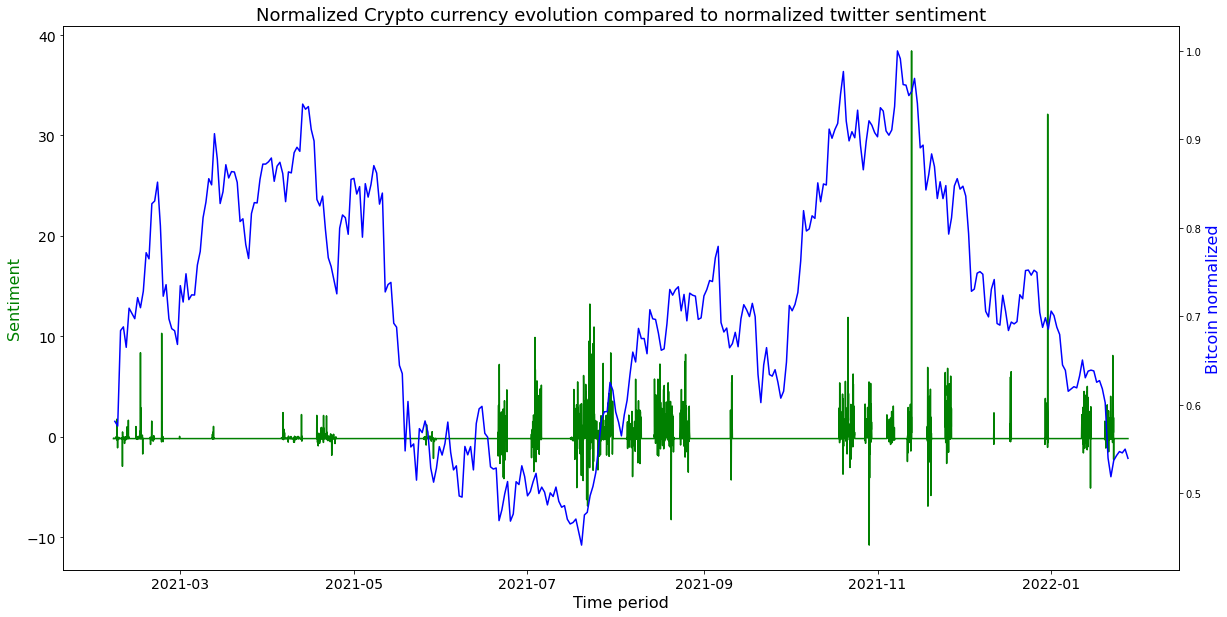

cell ok


<Figure size 432x288 with 0 Axes>

In [12]:
# Normalize time series data
min_max_scaler = preprocessing.StandardScaler()
score_scaled = min_max_scaler.fit_transform(tweets_sampled['score'].values.reshape(-1, 1))#归一化
tweets_sampled['normalized_score'] = score_scaled
# crypto_used_grouped_scaled = min_max_scaler.fit_transform(crypto_usd_grouped.values.reshape(-1,1))
crypto_used_grouped_scaled = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))
# crypto_usd_grouped['normalized_price'] = crypto_used_grouped_scaled

fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_sampled.index, tweets_sampled['normalized_score'], 'g-')#归一化后的推文
ax2.plot_date(crypto_usd_grouped.index, crypto_used_grouped_scaled, 'b-')#价格

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax1.set_xlabel("Time period", fontsize=16)
ax2.set_ylabel("Bitcoin normalized", color='b', fontsize=16)
plt.show()
plt.savefig('normalized_crypto_evolution_vs_twitter_sentiment', dpi=1000)
print('cell ok')

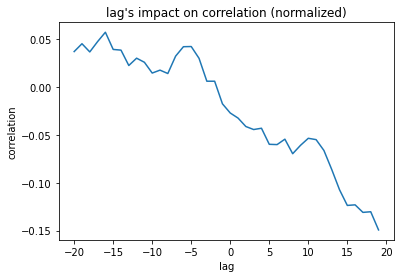

cell ok


In [13]:
#tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
#tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
xcov = [crosscorr(tweets_sampled, crypto_usd_grouped, lag=i) for i in range(-20, 20)]
plt.plot(range(-20, 20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()
print('cell ok')

## Derivative of Crypto price 

In [14]:
# Derivative
tweets_grouped_derivative = pd.Series(np.gradient(tweets_sampled['normalized_score'].values), tweets_sampled.index,
                                      name='slope')#推文
crypto_usd_grouped_derivative = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index,
                                          name='slope')#价格
print('cell ok')

cell ok


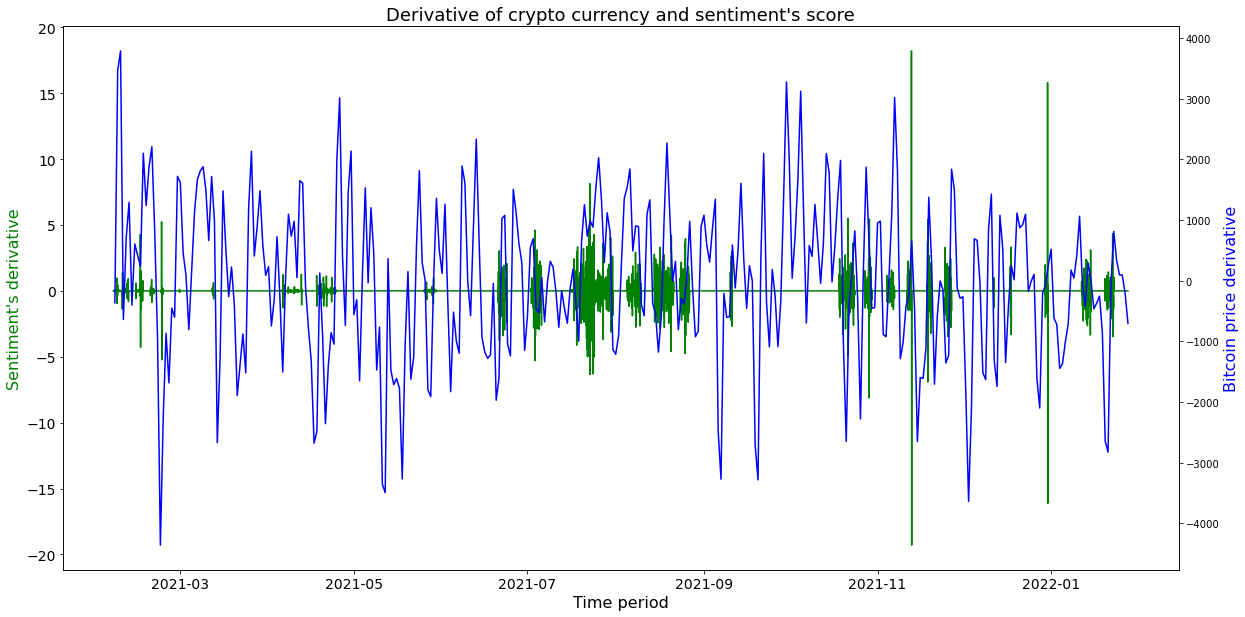

cell ok


<Figure size 432x288 with 0 Axes>

In [15]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.set_xlabel("Time period", fontsize=16)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped_derivative.index, tweets_grouped_derivative, 'g-')
ax2.plot_date(crypto_usd_grouped_derivative.index, crypto_usd_grouped_derivative, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel('Bitcoin price derivative', color='b', fontsize=16)
plt.show()
plt.savefig('derivative_crypto_currency_vs_twitter_sentiment', dpi=1000)
print('cell ok')

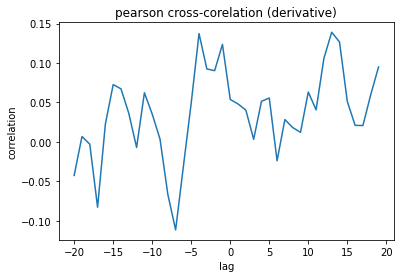

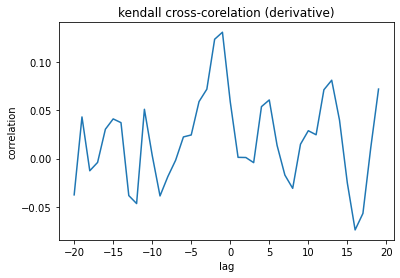

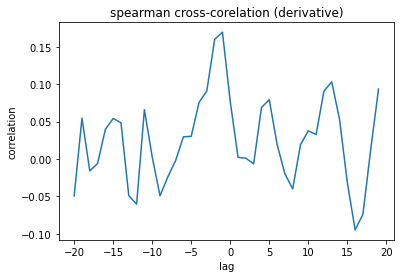

cell ok


In [16]:
xcov = [crosscorr(tweets_sampled, crypto_usd_grouped_derivative, lag=i, method="pearson") for i in range(-20, 20)]
plt.plot(range(-20, 20), xcov)
plt.title("pearson cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_sampled, crypto_usd_grouped_derivative, lag=i, method="kendall") for i in range(-20, 20)]
plt.plot(range(-20, 20), xcov)
plt.title("kendall cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_sampled, crypto_usd_grouped_derivative, lag=i, method="spearman") for i in range(-20, 20)]
plt.plot(range(-20, 20), xcov)
plt.title("spearman cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()
print('cell ok')

# NLP Modeling 

In [17]:
df = tweets_clean_df.copy()
df.dropna(subset=['hashtags'], inplace=True)
df = df[['text']]
df.columns = ['tweets']
df.head()
print('cell ok')

cell ok


In [18]:
print('cell start')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words(['english'])

# stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",
#               'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
#               'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what',
#               'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were',
#               'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the',
#               'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about',
#               'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
#               'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
#               'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
#               'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can',
#               'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain',
#               'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
#               "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
#               "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't",
#               'wouldn', "wouldn't"]

print(stop_words)
print('cell ok')

cell start
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so'

In [19]:
lem = WordNetLemmatizer()


def cleaning(data):
    #remove urls
    tweet_without_url = re.sub(r'http\S+', ' ', data)

    #remove hashtags
    tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

    #3. Remove mentions and characters that not in the English alphabets
    tweet_without_mentions = re.sub(r'@\w+', ' ', tweet_without_hashtag)
    precleaned_tweet = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)

    #2. Tokenize
    tweet_tokens = TweetTokenizer().tokenize(precleaned_tweet)

    #3. Remove Puncs
    tokens_without_punc = [w for w in tweet_tokens if w.isalpha()]

    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #5. lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]

    #6. Joining
    return " ".join(text_cleaned)


print('cell ok')

cell ok


In [20]:
# nltk
print('cell start')
df['cleaned_tweets'] = df['tweets'].apply(cleaning)
print(df['cleaned_tweets'])
df['date'] = tweets_clean_df['date']
df['date_clean'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d') #转换时间格式
df.drop(columns='date', inplace=True)
df.head()
print('cell ok')

cell start
0        NEW BITCOIN UPDATE Market manipulation price t...
1        Tesla Reports M Bitcoin Lost BTC bearish Crypt...
2        I find curious C Founder think BTC consensus n...
3                                      Bitcoin like Monica
4        We back another CryptoLingo What ATL The lowes...
                               ...                        
39531    BITO This going HUGE The first EVER I S bitcoi...
39532    I know many scenario terrible already planning...
39533    Translation I understand Bitcoin apart flickin...
39534    We organizing personal donation Ukraine drivin...
39535    YieldFarming Airdrop Binance BNB BSC PancakeSw...
Name: cleaned_tweets, Length: 39353, dtype: object
cell ok


In [21]:
def getSubjectivity(tweet):#用函数获取subjectivity值
    return TextBlob(tweet).sentiment.subjectivity #主观性


def getPolarity(tweet):#用函数获取polarity值
    return TextBlob(tweet).sentiment.polarity


print('cell ok')

cell ok


In [22]:
def crypto_price_cate(score): #将价格score进行分类打标
    if score < 1:
        return 'negative'
    elif score == 1:
        return 'neutral'
    else:
        return 'positive'

##比特币价格打标签
def observe_period(period):
    res = crypto_usd_grouped.shift(period) / crypto_usd_grouped
    res = res.apply(crypto_price_cate)
    return res


time_sentiment = observe_period(7)  # compare price ratio in 7 days. price_7_days_later/ price_now 7天涨跌幅计算情感标签
df['crypto_sentiment'] = df.date_clean.apply(lambda x: time_sentiment[x] if x in time_sentiment else np.nan)
print('cell ok')

cell ok


In [23]:
# 计算推文的suvjectivity和polarity值
df['subjectivity'] = df['cleaned_tweets'].apply(getSubjectivity)#主观倾向
df['polarity'] = df['cleaned_tweets'].apply(getPolarity)#正负面程度
df.head()
print('cell ok')

cell ok


In [24]:
def getSentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

#文本价格两种计算方式 0-1 
df['sentiment'] = df['polarity'].apply(getSentiment)#将polarity代入
df['target'] = df['sentiment'] == df['crypto_sentiment']
df.head()
df.to_csv('./df_data.csv')
print('cell ok')

#nltk wordnet>>embbeding word2vec, bag of words 数据量不大

cell ok


0        positive
1             NaN
2             NaN
3        positive
4        negative
           ...   
39531    negative
39532    positive
39533    positive
39534         NaN
39535         NaN
Name: crypto_sentiment, Length: 39353, dtype: object


/Users/yeahyeah/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


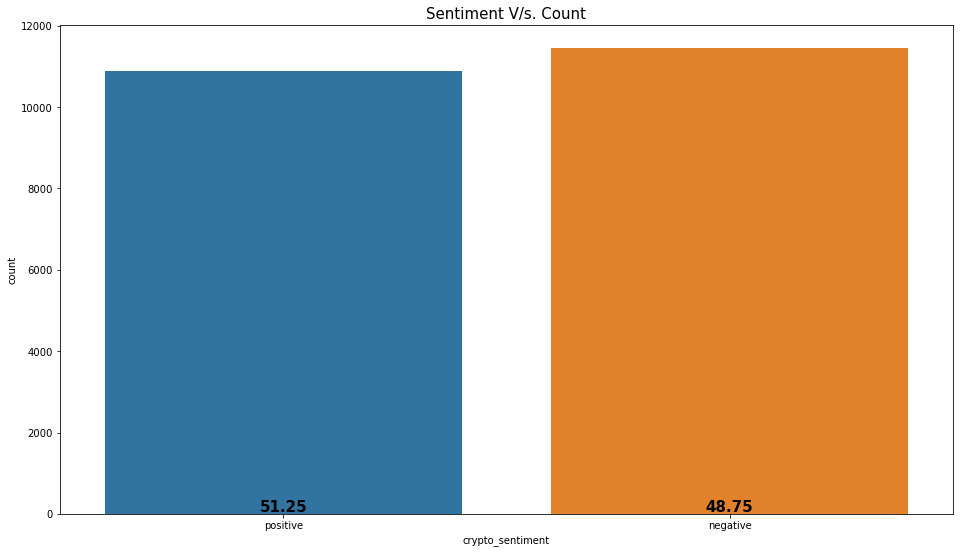

cell ok


<Figure size 432x288 with 0 Axes>

In [25]:
import seaborn as sns

plt.figure(figsize=[16, 9])
print(df.crypto_sentiment)
sns.countplot(df.crypto_sentiment)
plt.title('Sentiment V/s. Count', fontsize=15)

label = (df.crypto_sentiment.value_counts(normalize=True) * 100).round(2)
for i in range(2):
    plt.text(x=i, y=label[i], s=label[i], horizontalalignment='center', rotation=360, color="black", weight="bold",
             fontsize=15)

plt.legend
plt.show()
plt.savefig('sentiment_vs_count', dpi=1000)
print('cell ok')

# Model preparation 

In [26]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

print('cell ok')

2022-11-25 23:02:47.635782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


cell ok


In [27]:
df.head()
print('cell ok')

cell ok


In [28]:
#x和y
X = df['cleaned_tweets']#处理后的推文文本
y = pd.get_dummies(df['sentiment']).values#情感标签
num_classes = df['sentiment'].nunique()
print('cell ok')

cell ok


In [29]:
seed = 38  # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('cell ok')

(31482,) (7871,) (31482, 3) (7871, 3)
cell ok


In [30]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)#分词，20000个
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)#转换为序列 ##数据的二维数组 y_train：特征序列(negative,positive ==score) 数据组 特征组 放一行
X_test = tokenizer.texts_to_sequences(X_test)
print('cell ok')

cell ok


In [31]:
from tensorflow.keras.preprocessing import sequence

max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape, X_test.shape)
print('cell ok')

(31482, 30) (7871, 30)
cell ok


In [32]:
#大模型
print('start')
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

batch_size = 128
epochs = 10

max_features = 20000
embed_dim = 100

np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))##wordnet向量化 nlp文字：向量化 待办 能让模型更好理解文字信息 #找到特征 减少维数+有意义 Embedding 是一个将离散变量转为连续向量表示的一个方式
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))#卷积层 提取特征 权重学习
model.add(MaxPooling1D(pool_size=2))#最大池化层 
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))#卷积层 简化操作，进LSTM里计算得更快 搭更多>>提取更多特征
model.add(MaxPooling1D(pool_size=2))#最大池化层 特征不变 特征降维 防止过拟合； 常用：2x2 步长为2；池化层降低输入的尺寸，变相的减少了整个网络的参数量
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))#100个是什么 第一个dropout是x和hidden之间的dropout,第二个是hidden-hidden之间的dropout
model.add(Dense(num_classes, activation='softmax'))#全连接层 Softmax计算简单，效果显著，非常好用。a>b 根据各自概率取a和b； 在 RNN 中，全连接用来把 embedding 空间拉到隐层空间，把隐层空间转回 label 空间等。
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])#损失函数，目标函数，优化评分函数 loss参数 待办。每一个选项对应的概念
model.summary()
print('cell ok')
##多加层数的卷积层>>提取 池化层减少运算量

start


2022-11-25 23:03:03.154509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               5

In [33]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=epochs, batch_size=batch_size, verbose=2)
#epoch是一个单位。 一个epoch表示学习中所有训练数据均被使用过一次时的更新次数。 
#比如，对于10000笔训练数据，用大小为100笔数据的mini-batch进行学习时，重复随机梯度下降法100次，所有的训练数据就都被看过了。
#此时100次就是一个epoch.
#batch_size:
#batchsize：中文翻译为批大小（批尺寸）。 简单点说，批量大小将决定我们一次训练的样本数目。 batch_size将影响到模型的优化程度和速度。
#verbose = 2 为每个epoch输出一行记录
#随机梯度

Epoch 1/10
246/246 - 23s - loss: 0.5063 - accuracy: 0.7978 - val_loss: 0.2286 - val_accuracy: 0.9269 - 23s/epoch - 95ms/step
Epoch 2/10
246/246 - 16s - loss: 0.1284 - accuracy: 0.9607 - val_loss: 0.1493 - val_accuracy: 0.9539 - 16s/epoch - 65ms/step
Epoch 3/10
246/246 - 18s - loss: 0.0539 - accuracy: 0.9849 - val_loss: 0.1668 - val_accuracy: 0.9525 - 18s/epoch - 73ms/step
Epoch 4/10
246/246 - 19s - loss: 0.0317 - accuracy: 0.9921 - val_loss: 0.1982 - val_accuracy: 0.9525 - 19s/epoch - 77ms/step
Epoch 5/10
246/246 - 17s - loss: 0.0232 - accuracy: 0.9935 - val_loss: 0.2227 - val_accuracy: 0.9513 - 17s/epoch - 67ms/step
Epoch 6/10
246/246 - 17s - loss: 0.0188 - accuracy: 0.9950 - val_loss: 0.2249 - val_accuracy: 0.9498 - 17s/epoch - 69ms/step
Epoch 7/10
246/246 - 17s - loss: 0.0154 - accuracy: 0.9957 - val_loss: 0.2496 - val_accuracy: 0.9491 - 17s/epoch - 69ms/step
Epoch 8/10
246/246 - 15s - loss: 0.0127 - accuracy: 0.9961 - val_loss: 0.2638 - val_accuracy: 0.9471 - 15s/epoch - 59ms/step


{'loss': [0.5063118934631348, 0.12843988835811615, 0.05388394370675087, 0.03173310309648514, 0.02315470576286316, 0.018761683255434036, 0.01535073108971119, 0.01267665158957243, 0.011834726668894291, 0.010970368050038815], 'accuracy': [0.7977574467658997, 0.9606759548187256, 0.9849438071250916, 0.9920907020568848, 0.9934566020965576, 0.9949812889099121, 0.9956800937652588, 0.9960930347442627, 0.996632993221283, 0.9968553185462952], 'val_loss': [0.22862599790096283, 0.14933905005455017, 0.16675497591495514, 0.19815762341022491, 0.2227136343717575, 0.2248893827199936, 0.24957658350467682, 0.2637675404548645, 0.31719061732292175, 0.2834932506084442], 'val_accuracy': [0.9269469976425171, 0.9538813233375549, 0.9524837732315063, 0.9524837732315063, 0.95134037733078, 0.9498157501220703, 0.9490534663200378, 0.947147786617279, 0.947147786617279, 0.9440985918045044]}
cell ok


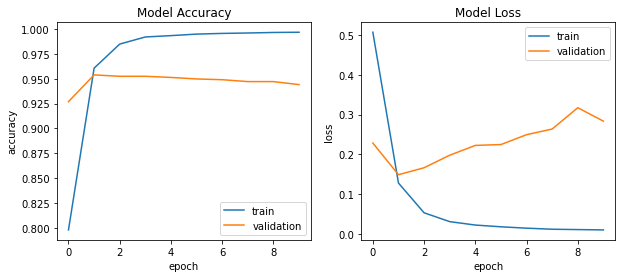

In [39]:
print(history.history)


def plot_training_hist(history, save_path, save_name):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

    plt.savefig(save_path + save_name, dpi=1000)


plot_training_hist(history, save_path = os.path.abspath('./target_output_tweet/'), save_name='target.png')
print('cell ok')

In [41]:
# predict class with test set
y_pred_test = np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test, axis=1), y_pred_test) * 100))
print(classification_report(np.argmax(y_test, axis=1), y_pred_test))
print('cell ok')
# Accuracy:	94.4%

246/246 [==============================] - 1s 6ms/step
Accuracy:	94.4%
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       885
           1       0.97      0.95      0.96      3201
           2       0.95      0.97      0.96      3785

    accuracy                           0.94      7871
   macro avg       0.92      0.91      0.92      7871
weighted avg       0.94      0.94      0.94      7871

cell ok


246/246 [==============================] - 1s 4ms/step
2    3785
1    3201
0     885
dtype: int64
2    3886
1    3148
0     837
dtype: int64
cell ok


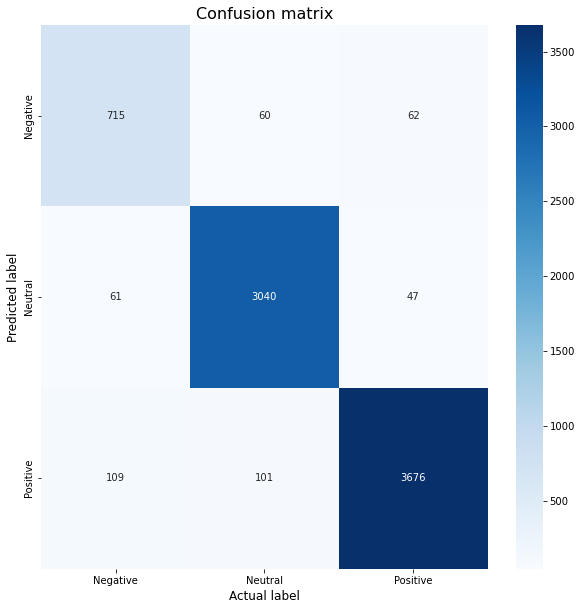

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(np.array(y_test), axis=1))

    print(pd.Series(np.argmax(np.array(y_test), axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())

    # plot confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    plt.savefig("train_matrix", dpi=1000)


plot_confusion_matrix(model, X_test, y_test)
print('cell ok')

In [43]:
# selected_importances = model.feature_importances_
# sorted_indices = np.argsort(selected_importances)[::-1]
# # Plot
# plt.title('Feature Importance')
# plt.bar(range(X_train.shape[1]), selected_importances[sorted_indices], align='center')
# plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
# plt.tight_layout()
# plt.show()

# Testing 

In [67]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len = 50


def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer


print('Before Tokenization & Padding \n', df['cleaned_tweets'][0])
X, tokenizer = tokenize_pad_sequences(df['cleaned_tweets'])
print('After Tokenization & Padding \n', X[0])
print('cell ok')

Before Tokenization & Padding 
 NEW BITCOIN UPDATE Market manipulation price target amp MORE fS pyme tw
After Tokenization & Padding 
 [  37    1  207   20 2484    8  183   22  228 2976    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
cell ok


In [68]:
y = pd.get_dummies(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)
print('cell ok')

Train Set:  (23611, 50) (23611, 3)
Validation Set:  (7871, 50) (7871, 3)
Test Set:  (7871, 50) (7871, 3)
cell ok


In [69]:
import tensorflow.keras.backend as K


def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val


print('cell ok')

cell ok


In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses
import csv
import tensorflow as tf

In [71]:
# 调参空间
# vocab_sizes：      词库大小
# embedding_sizes：  每个词的二次映射大小
# epochs:           训练轮数
# learning_rates：   学习率
# momentums：        SGD优化器参数摩擦系数
# batch_sizes:      批次大小
# drop_out_rates：   随机剪枝比率
vocab_sizes = [5000]
embedding_sizes = [32]
epochs = 50
learning_rates = [0.02]
momentums = [0.9]
batch_sizes = [128]
drop_out_rates = [0.2]

#Accuracy  : 0.9483
#Precision : 0.9510
#Recall    : 0.9461
#F1 Score  : 0.9485

In [72]:
save_path = os.path.abspath('./target_output_tweet/')
file = open(save_path + 'log', 'a+', encoding='utf-8', newline='')
csv_writer = csv.writer(file)
csv_writer.writerow(
    [f'vocab_size', 'embedding_size', 'learning_rate', 'momentum', 'batch_size', 'drop_out_rate', 'Accuracy',
     'Precision', 'Recall', 'F1 Score'])
print('cell ok')


cell ok


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 32)            160000    
                                                                 
 conv1d_4 (Conv1D)           (None, 50, 32)            1056      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 25, 32)            1056      
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64)               

Epoch 30/50
185/185 [==============================] - 7s 40ms/step - loss: 0.1044 - accuracy: 0.9729 - precision_1: 0.9747 - recall_1: 0.9711 - val_loss: 0.2136 - val_accuracy: 0.9483 - val_precision_1: 0.9511 - val_recall_1: 0.9459
Epoch 31/50
185/185 [==============================] - 6s 33ms/step - loss: 0.1004 - accuracy: 0.9738 - precision_1: 0.9761 - recall_1: 0.9720 - val_loss: 0.2157 - val_accuracy: 0.9478 - val_precision_1: 0.9496 - val_recall_1: 0.9460
Epoch 32/50
185/185 [==============================] - 6s 33ms/step - loss: 0.0980 - accuracy: 0.9742 - precision_1: 0.9760 - recall_1: 0.9728 - val_loss: 0.2125 - val_accuracy: 0.9529 - val_precision_1: 0.9542 - val_recall_1: 0.9507
Epoch 33/50
185/185 [==============================] - 6s 32ms/step - loss: 0.0984 - accuracy: 0.9729 - precision_1: 0.9753 - recall_1: 0.9715 - val_loss: 0.2337 - val_accuracy: 0.9417 - val_precision_1: 0.9429 - val_recall_1: 0.9395
Epoch 34/50
185/185 [==============================] - 7s 36ms/s

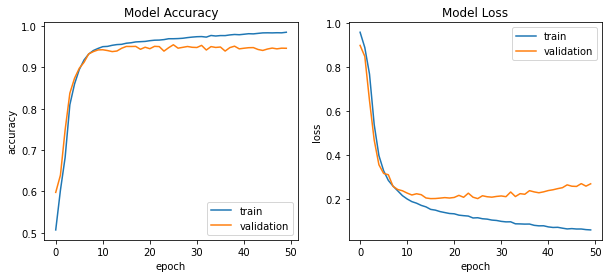

In [73]:
# Build model
for vocab_size in vocab_sizes:
    for embedding_size in embedding_sizes:
        for learning_rate in learning_rates:
            for momentum in momentums:
                for batch_size in batch_sizes:
                    for drop_out_rate in drop_out_rates:
                        plot_file_name = str(vocab_size) + '_' + str(embedding_size) + '_' + str(
                            learning_rate) + '_' + str(momentum) + '_' + str(batch_size) + '_' + str(
                            drop_out_rate) + '.png'
                        decay_rate = learning_rate / epochs
                        sgd = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
                        model = Sequential()
                        model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
                        model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))#ReLU很重要：ReLU的目的是在我们的ConvNet中引入非线性。 因为，现实世界数据希望我们的ConvNet学习是非负线性值
                        model.add(MaxPooling1D(pool_size=2))
                        model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
                        model.add(Bidirectional(LSTM(32)))#双向LTSM？ 这里为什么用这个 因为能获取到更多的信息 对比前一个吗？ 连接上下文 得到更多信息
                        model.add(Dropout(0.4))
                        model.add(Dense(3, activation='softmax'))
                        model.summary()
                        model.compile(loss='categorical_crossentropy', optimizer=sgd,
                                      metrics=['accuracy', Precision(), Recall()])
                        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size,
                                            epochs=epochs, verbose=1)
                        # Evaluate model on the test set
                        loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
                        # Print metrics
                        print('')
                        print('Accuracy  : {:.4f}'.format(accuracy))
                        print('Precision : {:.4f}'.format(precision))
                        print('Recall    : {:.4f}'.format(recall))
                        print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))
                        print('cell ok')
                        csv_writer.writerow(
                            [vocab_size, embedding_size, learning_rate, momentum, batch_size, drop_out_rate, accuracy,
                             precision, recall, f1_score(precision, recall)])
                        plot_training_hist(history, save_path=save_path, save_name=plot_file_name)

## Price Prediction

In [60]:
! pip install pandas_datareader

In [61]:
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

crypto_currency = 'BTC'
against_currency = 'USD'

data = pd.read_csv('./BTC-USD.csv')
print('cell ok')

cell ok


In [62]:
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [63]:
scaler = MinMaxScaler(feature_range=(0, 1))#归一化数值
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
#预处理 归一化
preddays = 10 #待预测日期

x_train, y_train = [], []
for x in range(preddays, len(scaled_data)):
    x_train.append(scaled_data[x - preddays:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print('cell ok')

cell ok


In [65]:
# 调参空间
# units:            一层LSTM所包含的单元数
# drop_out_rates：   随机剪枝比率
# batch_sizes:      批次大小
units = [200]
drop_out_rates = [0.1]
batch_sizes = [32]
# RMSE: 1717.0013020669314

cell ok
Epoch 1/50
84/84 [==============================] - 14s 79ms/step - loss: 0.0039
Epoch 2/50
84/84 [==============================] - 6s 72ms/step - loss: 0.0011
Epoch 3/50
84/84 [==============================] - 6s 70ms/step - loss: 0.0010
Epoch 4/50
84/84 [==============================] - 5s 64ms/step - loss: 0.0011
Epoch 5/50
84/84 [==============================] - 6s 72ms/step - loss: 8.1364e-04
Epoch 6/50
84/84 [==============================] - 6s 74ms/step - loss: 9.1390e-04
Epoch 7/50
84/84 [==============================] - 9s 102ms/step - loss: 9.4879e-04
Epoch 8/50
84/84 [==============================] - 7s 78ms/step - loss: 7.6391e-04
Epoch 9/50
84/84 [==============================] - 5s 63ms/step - loss: 7.7774e-04
Epoch 10/50
84/84 [==============================] - 5s 64ms/step - loss: 7.2768e-04
Epoch 11/50
84/84 [==============================] - 7s 81ms/step - loss: 8.3541e-04
Epoch 12/50
84/84 [==============================] - 7s 78ms/step - loss: 7.0049

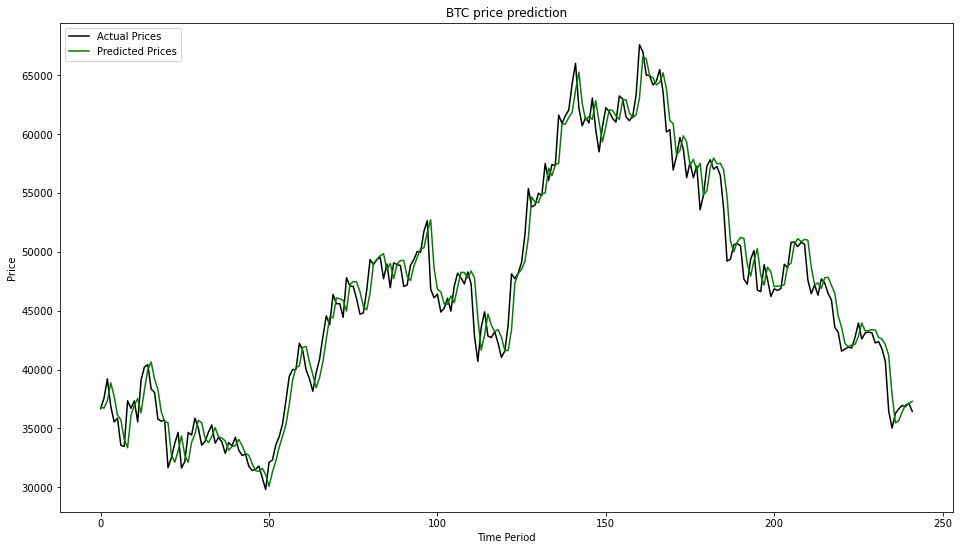

cell ok


<Figure size 432x288 with 0 Axes>

In [66]:
save_path =os.path.abspath('./target_output_price/')
file = open(save_path + 'log', 'a+', encoding='utf-8', newline='')
csv_writer = csv.writer(file)
csv_writer.writerow(
    [f'unit', 'drop_out_rate', 'batch_size', 'RMSE'])
print('cell ok')

for unit in units:
    for drop_out_rate in drop_out_rates:
        for batch_size in batch_sizes:
            plot_file_name = str(unit) + '_' + str(drop_out_rate) + '_' + str(batch_size) + '.png'

            model = Sequential()#基于栈式 LSTM 的序列分类 ##只有数据 不是文本
            model.add(LSTM(units=unit, return_sequences=True, input_shape=(x_train.shape[1], 1)))
            model.add(Dropout(drop_out_rate))
            model.add(LSTM(units=unit, return_sequences=True))
            model.add(Dropout(drop_out_rate))
            model.add(LSTM(units=unit))
            model.add(Dropout(drop_out_rate))
            model.add(Dense(units=1))

            model.compile(optimizer='adam', loss='mean_squared_error')
            history = model.fit(x_train, y_train, epochs=50, batch_size=batch_size, verbose=1)

            test_start = dt.datetime(2021, 6, 1)
            test_end = dt.datetime.now()
            # print(data['Date'])
            test_data = data.loc[
                (pd.to_datetime(data['Date']) >= test_start) & (pd.to_datetime(data['Date']) <= test_end)]
            actual_prices = test_data['Close'].values
            total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

            model_inputs = total_dataset[len(total_dataset) - len(test_data) - preddays:].values
            model_inputs = model_inputs.reshape(-1, 1)
            model_inputs = scaler.fit_transform(model_inputs)
            x_test = []

            for x in range(preddays, len(model_inputs)):
                x_test.append(model_inputs[x - preddays:x, 0])

            x_test = np.array(x_test)
            x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
            print('cell ok')
            pred = model.predict(x_test)
            pred = scaler.inverse_transform(pred)

            # 评价指标RMSE，越小越好
            RMSE = np.sqrt(mean_squared_error(pred, actual_prices))
            print('RMSE: ', RMSE)

            csv_writer.writerow([unit, drop_out_rate, batch_size, RMSE])

            plt.figure(figsize=(16, 9))
            plt.plot(actual_prices, color='black', label='Actual Prices')
            plt.plot(pred, color='green', label='Predicted Prices')
            plt.title(f'BTC price prediction')
            plt.xlabel('Time Period')
            plt.ylabel('Price')
            plt.legend(loc='upper left')
            plt.show()
            plt.savefig(save_path + plot_file_name, dpi=1000)
            # print("The Predicted price of Bitcoin for today is $" + str(float(pred[-1])))
            # print("The last hour's close price of Bitcoin is $" + str(float(data.tail(1)['Close'])))
            print('cell ok')